In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
from qutip import * 
from scipy.stats import unitary_group

## The parameters 

In [2]:
Na = 3
M = 500
h = np.pi / 4
J = np.pi / 4
g = np.pi / 9
b = np.pi / 4
t = 3

## The Haar ensemble 

In [3]:
def haar_random_state(N_A):
    U = unitary_group.rvs(2**N_A)
    return Qobj(U[:, 0])

def moment_operator(psi, k):
    rho = psi * psi.dag()
    return tensor([rho] * k)

def haar_moment(N_A, k, M):
    acc = 0
    for _ in range(M):
        psi = haar_random_state(N_A)
        acc += moment_operator(psi, k)
    return acc / M

## Building the N qubit chain

In [4]:
def operator_on_site(op, i, N):
    ops = [qeye(2)] * N
    ops[i] = op
    return tensor(ops)

def projector_on_B(z_B, Na, N):
    id_A = [qeye(2) for _ in range(Na)]
    proj_B = [basis(2, b) * basis(2, b).dag() for b in z_B]
    return tensor(id_A + proj_B)

## The Crux 

In [6]:
all_results = {}


def moment_k(ensemble, k):
    acc = 0
    for psi in ensemble:
        rho = psi * psi.dag()
        rho_k = tensor([rho] * k)
        acc += rho_k
    return acc / len(ensemble)

for k in range(1, 5): 
    print(f'Computing Haar moment for k = {k}')
    rho_haar_k = haar_moment(Na, k, M)
    results = []

    for Nb in range(2, 10): 
        N = Na + Nb 
        print(f'Running Nb = {Nb} (N = {N})')

        # Hamiltonian
        H_Ising = b * (operator_on_site(sigmaz(), 0, N) + operator_on_site(sigmaz(), N - 1, N))
        for i in range(N - 1):
            H_Ising += J * operator_on_site(sigmaz(), i, N) * operator_on_site(sigmaz(), i + 1, N)
        for i in range(N):
            H_Ising += g * operator_on_site(sigmaz(), i, N)

        H_h = sum(h * operator_on_site(sigmay(), i, N) for i in range(N))
        U_F = (-1j * H_h).expm() * (-1j * H_Ising).expm()

        U_t = U_F
        for _ in range(t - 1):
            U_t = U_t * U_F

        # Initial state
        plus = (basis(2, 0) + basis(2, 1)).unit()
        plus_N = tensor([plus] * N)
        psi_t = U_t * plus_N

        # Monte Carlo ensemble
        ensemble = []
        for _ in range(M):
            z_B = np.random.randint(0, 2, size=Nb)
            P_zB = projector_on_B(z_B, Na, N)
            psi_tilde = P_zB * psi_t
            rho_full = psi_tilde * psi_tilde.dag()
            rho_A = rho_full.ptrace(list(range(Na)))
            eigvals, eigvecs = rho_A.eigenstates()
            psi_A = eigvecs[0].unit()
            ensemble.append(psi_A)

        # Build empirical moment
        rho_E_k = moment_k(ensemble, k)
        dim = 2 ** (Na * k)
        rho_E_k.dims = [[dim], [dim]]

        # (2) Clone and reset Haar dims locally
        rho_haar_k_local = rho_haar_k.copy()
        rho_haar_k_local.dims = [[dim], [dim]]

        # Calculate the trace distance
        delta_k = tracedist(rho_E_k, rho_haar_k_local)
        results.append((Nb, delta_k))

    #Store the results 
    all_results[k] = results


Computing Haar moment for k = 1
Running Nb = 2 (N = 5)
Running Nb = 3 (N = 6)
Running Nb = 4 (N = 7)
Running Nb = 5 (N = 8)
Running Nb = 6 (N = 9)
Running Nb = 7 (N = 10)
Running Nb = 8 (N = 11)
Running Nb = 9 (N = 12)
Computing Haar moment for k = 2
Running Nb = 2 (N = 5)
Running Nb = 3 (N = 6)
Running Nb = 4 (N = 7)
Running Nb = 5 (N = 8)
Running Nb = 6 (N = 9)
Running Nb = 7 (N = 10)
Running Nb = 8 (N = 11)
Running Nb = 9 (N = 12)
Computing Haar moment for k = 3
Running Nb = 2 (N = 5)
Running Nb = 3 (N = 6)
Running Nb = 4 (N = 7)
Running Nb = 5 (N = 8)
Running Nb = 6 (N = 9)
Running Nb = 7 (N = 10)
Running Nb = 8 (N = 11)
Running Nb = 9 (N = 12)
Computing Haar moment for k = 4
Running Nb = 2 (N = 5)
Running Nb = 3 (N = 6)
Running Nb = 4 (N = 7)
Running Nb = 5 (N = 8)
Running Nb = 6 (N = 9)
Running Nb = 7 (N = 10)
Running Nb = 8 (N = 11)
Running Nb = 9 (N = 12)


k = 1, # of points: 8
sample entry: (2, np.float64(0.5912858462073457))
k = 2, # of points: 8
sample entry: (2, np.float64(0.8882177765401746))
k = 3, # of points: 8
sample entry: (2, np.float64(0.9681447974406514))
k = 4, # of points: 8
sample entry: (2, np.float64(0.9867487113717154))


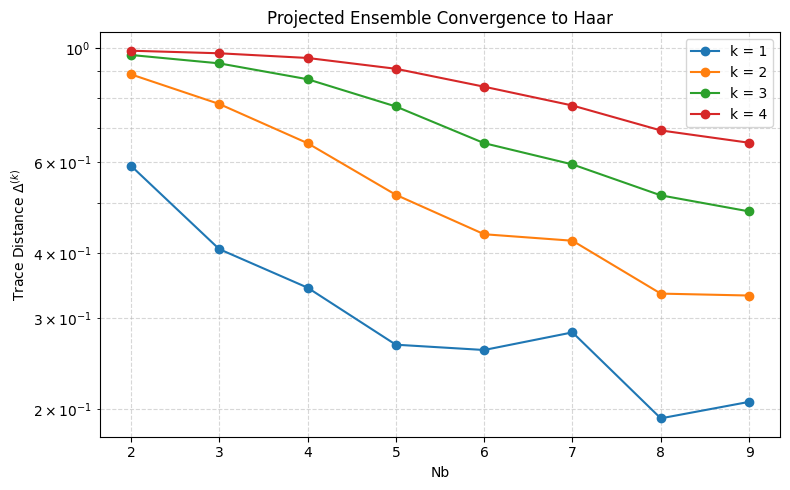

In [9]:
for k, results in all_results.items():
    print(f"k = {k}, # of points: {len(results)}")
    print("sample entry:", results[0])


plt.figure(figsize=(8, 5))
for k, results in all_results.items():
    Nb_vals, delta_vals = zip(*results)
    plt.semilogy(Nb_vals, delta_vals, marker='o', label=f'k = {k}')

plt.xlabel('Nb')
plt.ylabel(r'Trace Distance $\Delta^{(k)}$')
plt.title('Projected Ensemble Convergence to Haar')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()